In [1]:
# importando e inicializando módulos
import string
import csv
import pandas as pd
import string
import nltk
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from nltk.probability import FreqDist
from unicodedata import normalize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_predict

import tensorflow as tf
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

import gensim
from gensim.models import Word2Vec, KeyedVectors

import matplotlib.pylab as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from wordcloud import WordCloud

Using TensorFlow backend.


1957 265
1    1957
0    1957
Name: Tipo, dtype: int64
formato do arquivo (3914, 2)
                                                  Texto  Tipo
1043  segundo ano que vou na festa e pretendo voltar...     1
2001          tem desfiles das bandas em trajes tipicos     1
694   se quiser entrar mais tarde no parque e deixar...     0
1979  unico problema sao filas gigantescas pros banh...     0
1631  fomos com criancas e adulto acima de anos todo...     1
448      so esta cada vez mais exigente e burocratizada     0
1194                  filas enormes para qualquer coisa     0
445   creio que esta situacao desagradavel seria res...     0
735   pouca variedade de comida visto a farta culina...     0
1092  para criancas legal chegue cedo aproveire apar...     0
Texto    0
Tipo     0
dtype: int64


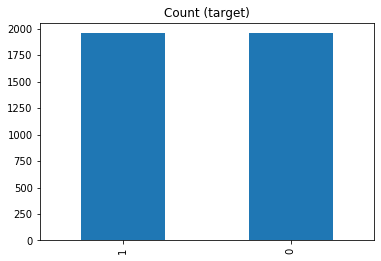

In [2]:
# carregando arquivo com as sentenças
filename='revisoes_oktober.csv'
dataset = pd.read_csv(filename,delimiter=',')

count_pos, count_neg = dataset.Tipo.value_counts()
print (count_pos, count_neg)

df_neg = dataset[dataset.Tipo==0.0]
df_pos = dataset[dataset.Tipo==1.0]
'''
# ramdomizar para under-sampling 
df_pos_under = df_pos.sample(count_neg)
dataset = pd.concat([df_pos_under, df_neg], axis=0)
print(dataset.Tipo.value_counts())
dataset.Tipo.value_counts().plot(kind='bar', title='Count (target)')
'''
# randomizar para over-sampling
df_neg_over = df_neg.sample(count_pos, replace=True)
dataset = pd.concat([df_pos, df_neg_over], axis=0)
print(dataset.Tipo.value_counts())
dataset.Tipo.value_counts().plot(kind='bar', title='Count (target)')

# linhas e colunas
print("formato do arquivo {}".format(dataset.shape))
print(dataset.sample(10))

# Verificando a existencia de dados nulos no dataset.
print(dataset.isnull().sum())

# separacao das colunas
sentences = dataset['Texto'].values.astype('U')
y = dataset.Tipo.values.astype('int32')

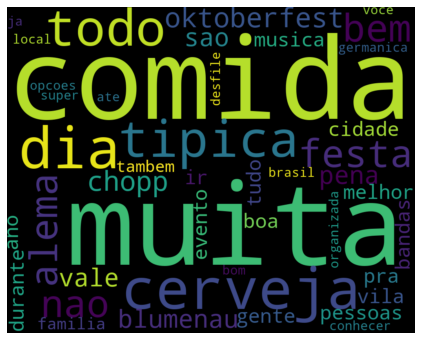

In [25]:
#### criar uma WordCloud das palavras mais frequentes nas frases positivas 

#dicionario de palavras em português
STOP_WORDS = stopwords.words('portuguese') + list(string.punctuation)
rslpsstemmer = RSLPStemmer() 

all_words_pos = []
for row in df_pos.Texto:
    for i in row.lower().split():
        if i not in STOP_WORDS:
            all_words_pos.append(i)

# frequencia das palavras
frequencia = FreqDist(all_words_pos)       
fdist = frequencia.most_common(50)

word_dict = []
for row in fdist:
    word_dict.append(row[0])
    
unique_string=(" ").join(word_dict)   
wordcloud = WordCloud(width=1000, height=800, margin=0).generate(unique_string)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

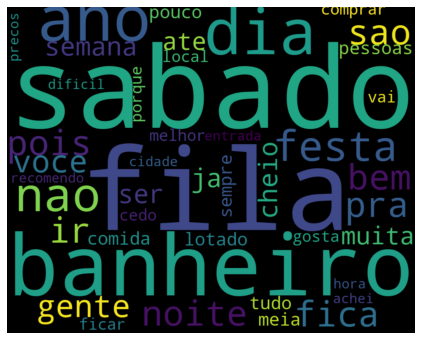

In [24]:
#### criar uma WordCloud das palavras mais frequentes nas frases negativas
all_words_neg = []
for row in df_neg.Texto:
    for i in row.lower().split():
        if i not in STOP_WORDS:
            all_words_neg.append(i)

# frequencia das palavras
frequencia = FreqDist(all_words_neg)       
fdist = frequencia.most_common(50)

word_dict = []
for row in fdist:
    word_dict.append(row[0])
    
unique_string=(" ").join(word_dict)   
wordcloud = WordCloud(width=1000, height=800, margin=0,                      
                     random_state=42).generate(unique_string)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

In [5]:
# pre-preparação das sentenças para classificação

all_words = []
sentence_words = []
for item in sentences:
    #print(item)
    # separa em palavras
    tokens = word_tokenize(item)    
    # remove todos os tokens que não são alfabetico
    words = [word for word in tokens if word.isalpha()]
    # remove as stopwords
    words = [word for word in words if not word in STOP_WORDS] 
    # remove acentuacao
    words = [normalize('NFKD', word).encode('ASCII', 'ignore').decode('ASCII') for word in words]
    # Stemming essa função serve para diminuirmos a palavra até a sua raiz/base
    #  "correr" e "corrida" == 'corr'          
    words = [rslpsstemmer.stem(word) for word in words]            
    # add todas as palavras na lista            
    [all_words.append(word) for word in words]
    
    sentence_words.append(words)
    
#print(sentence_words)   
#print(all_words)

# frequencia das palavras
frequencia = FreqDist(all_words)       

topfreq = frequencia.most_common(30)
#for word in topfreq:
#    print(word) #   top 100 palavras  

## resolvendo Imbalanced datasets
> * https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
> * https://elitedatascience.com/imbalanced-classes
> * https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18    

Random under-sampling:
1    1957
0    1957
Name: Tipo, dtype: int64


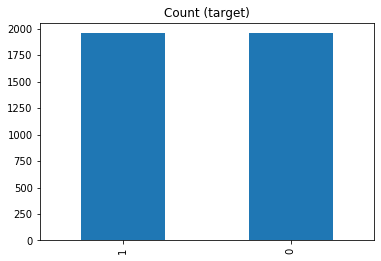

In [6]:
from sklearn.utils import resample

# Class count
count_neg_0, count_pos_1 = dataset.Tipo.value_counts()

# Divide by class
df_class_0 = dataset[dataset['Tipo'] == 0]
df_class_1 = dataset[dataset['Tipo'] == 1]

# Upsample minority class
df_class_0_under = resample(df_class_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_class_0),    # to match majority class
                                 random_state=27) # reproducible results

#df_class_0_under = df_class_0.sample(count_pos_1)
df_test_under = pd.concat([df_class_0, df_class_0_under], axis=0)

print('Random under-sampling:')
print(df_test_under.Tipo.value_counts())

df_test_under.Tipo.value_counts().plot(kind='bar', title='Count (target)');

In [7]:
## preparando o conjunto de treinamento e teste
# 
sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentence_words, y, test_size=0.25, random_state=42)

# bag-of-words to a matrix of TF-IDF features
bow_vectorizer = CountVectorizer(max_df=0.9, min_df=1, analyzer='word')

# percorre a list_sentences e cria uma unica lista separada por virgula
bow_train = []
for posicao in range(len(sentences_train)):     # por índice
    x = ' '.join(sentences_train[posicao])
    bow_train.append(x)

bow_test = []
for posicao in range(len(sentences_test)):     # por índice
    x = ' '.join(sentences_test[posicao])
    bow_test.append(x)

# dataset de treinamento e teste    
X_train = bow_vectorizer.fit_transform(bow_train)  
X_test = bow_vectorizer.transform(bow_test)
X_train

<2935x1794 sparse matrix of type '<class 'numpy.int64'>'
	with 26512 stored elements in Compressed Sparse Row format>

Acurácia: 0.9591
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1471
           1       0.99      0.93      0.96      1464

   micro avg       0.96      0.96      0.96      2935
   macro avg       0.97      0.96      0.96      2935
weighted avg       0.97      0.96      0.96      2935



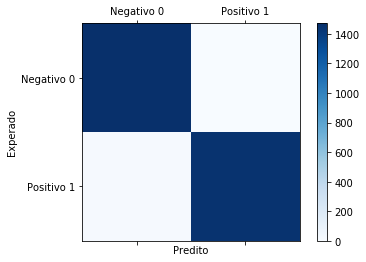

In [8]:
# Classificando com MODELO DE LOGISTIC REGRESSION

entries = []

logReg = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=21)
logReg.fit(X_train, y_train)
y_pred = logReg.predict(X_train)
resultados = cross_val_predict(logReg, X_train, y_train, cv=10)

model_name = "LogisticRegression"
acc = logReg.score(X_test, y_test)

entries.append((model_name, acc))
cv_df = pd.DataFrame(entries, columns=['model name','accuracy', ])

print("Acurácia: {:.4f}".format(acc))
print(metrics.classification_report(y_train, resultados))

# matriz de confusão
#print(pd.crosstab(y_train, y_pred, rownames = ["Real"], colnames=["Predito"], margins=True))
mat_conf = pd.crosstab(y_train, y_pred)

labels = ['Negativo 0', 'Positivo 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(mat_conf, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predito')
plt.ylabel('Experado')
plt.show()

Acurácia: 0.8944
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1471
           1       0.93      0.85      0.89      1464

   micro avg       0.89      0.89      0.89      2935
   macro avg       0.90      0.89      0.89      2935
weighted avg       0.90      0.89      0.89      2935

Matriz de Confusão do modelo MultinomialNB
col_0     0     1
row_0            
0      1391    80
1       146  1318


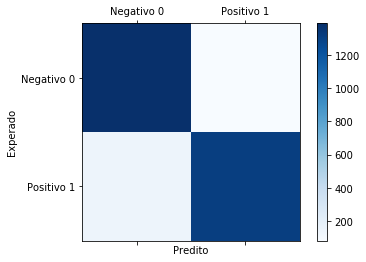

In [9]:
# Classificando com MODELO TFIDF
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_train)
resultados = cross_val_predict(mnb, X_train, y_train, cv=10)
#resultados
acc = metrics.accuracy_score(y_train, resultados)

model_name = "MultinomialNB"
#acc = mnb.score(X_test, y_test)

entries.append((model_name, acc))
cv_df = pd.DataFrame(entries, columns=['model name','accuracy'])

print("Acurácia: {:.4f}".format(acc))

print(metrics.classification_report(y_train, resultados))

# matriz de confusão
conf_matrix = pd.crosstab(y_train, y_pred)
print("Matriz de Confusão do modelo MultinomialNB")
print(conf_matrix)

labels = ['Negativo 0', 'Positivo 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predito')
plt.ylabel('Experado')
plt.show()

           model name  accuracy
0  LogisticRegression  0.959142
1       MultinomialNB  0.894378


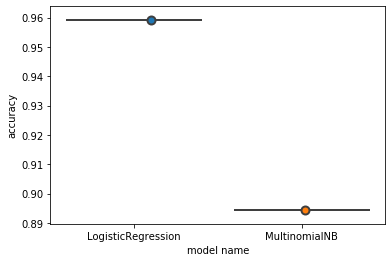

In [10]:
print(cv_df)

import seaborn as sns

ax = sns.boxplot(x="model name", y="accuracy", data=cv_df, linewidth=2)
ax = sns.stripplot(x="model name", y="accuracy", data=cv_df,
                  size=8, jitter=True, edgecolor="gray", linewidth=2)


In [11]:
## WORD2VEC 

# train model
model = Word2Vec(sentence_words, min_count=1)
# summarize vocabulary
words = list(model.wv.vocab)

word_vectors = model.wv

In [12]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 1971


In [13]:
word_vectors.most_similar(positive=['oktoberfest','chop'], negative=['fil'])

[('alem', 0.9994899034500122),
 ('alemanh', 0.9994856715202332),
 ('tipic', 0.9994617700576782),
 ('cervej', 0.9994420409202576),
 ('danc', 0.9994394779205322),
 ('boa', 0.9994301795959473),
 ('music', 0.9994286298751831),
 ('band', 0.9994219541549683),
 ('brasil', 0.9994202852249146),
 ('gastronom', 0.9994168281555176)]

In [14]:

X_train, X_test, y_train, y_test = train_test_split(sentence_words, y, test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [15]:
max_length = 4
nb_classes = 2

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % vocab_size)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = sequence.pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = sequence.pad_sequences(sequences_test, maxlen=max_length, padding='post')
X_val = sequence.pad_sequences(sequences_val, maxlen=max_length, padding='post')

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
y_val = np_utils.to_categorical(y_val, nb_classes)


Found 1636 unique tokens.


In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, 32),
    tf.keras.layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2, trainable=True),       
    tf.keras.layers.Dense(nb_classes, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          52352     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense (Dense)                (None, 2)                 18        
Total params: 53,682
Trainable params: 53,682
Non-trainable params: 0
_________________________________________________________________


In [17]:
#
nb_epoch = 10
history = model.fit(X_train, y_train, epochs=nb_epoch, shuffle=True, verbose=False, 
                    validation_data=(X_val, y_val))

In [18]:
#metricas de precisão
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9934
Testing Accuracy:  0.9285


In [19]:
# aplicando Precision-Recall

y_pred = model.predict(X_test)

# convert Y_test em 1D array
yy_true = [np.argmax(i) for i in y_test]
#print(yy_true)

yy_scores = [np.argmax(i) for i in y_pred]
#print(yy_scores)

print("Recall: {:.4f}".format(recall_score(yy_true, yy_scores, average="weighted")))
print("Precision: {:.4f}".format(precision_score(yy_true, yy_scores, average="weighted")))
print("F1_Score: {:.4f}".format(f1_score(yy_true, yy_scores, average="weighted")))

Recall: 0.9295
Precision: 0.9368
F1_Score: 0.9293


In [22]:
# aplicar a Matriz de Confusão
Y_pred = model.predict(X_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(2):
    print(ix, confusion_matrix(np.argmax(y_test, axis=1), y_pred)[ix].sum())

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print("=== Confusion Matrix ===")
print(cm)

979/1 - 0s
0 486
1 493
=== Confusion Matrix ===
[[483   3]
 [ 66 427]]


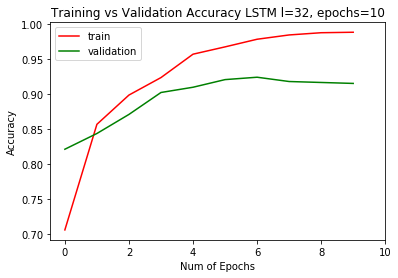

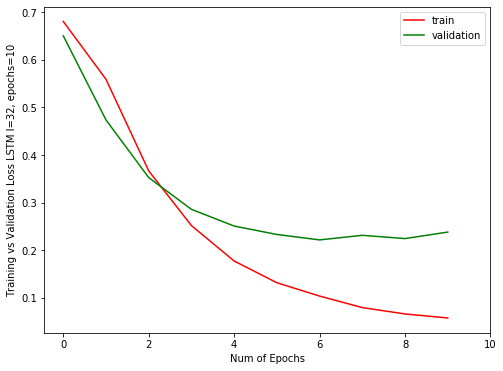

In [21]:

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy LSTM l=32, epochs=10") # for max length = 10 and 20 epochs
plt.legend(['train', 'validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Training vs Validation Loss LSTM l=32, epochs=10") # for max length = 10 and 20 epochs
plt.legend(['train', 'validation'])

plt.show()